In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Fit_Routines_Examples import *

_u = 1e6
_G = 1e-9


In [2]:
V_flux = np.load(path_to_arrays+"V_flux_{}.npy".format(ExpName))
S21 = np.load(path_to_arrays+"S21_{}.npy".format(ExpName))
freq = np.load(path_to_arrays+"freq_{}.npy".format(ExpName))

V_flux *= _u
S21 = np.abs(S21)
freq *= _G

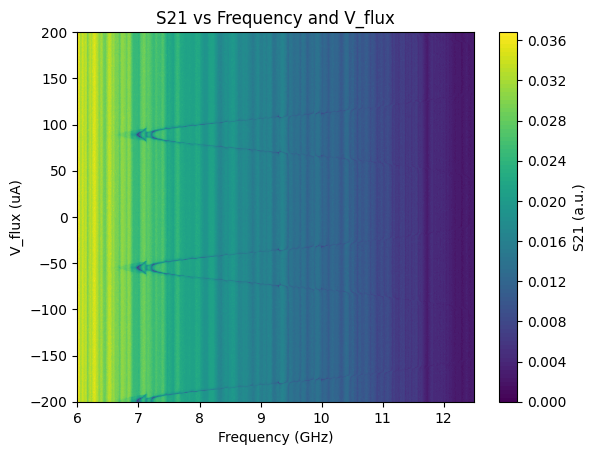

In [3]:

freq_grid, V_flux_grid = np.meshgrid(freq, V_flux)
plt.contourf(freq_grid, V_flux_grid, S21, levels=100, cmap='viridis')
plt.colorbar(label='S21 (a.u.)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('V_flux (uA)')
plt.title('S21 vs Frequency and V_flux')
plt.show()

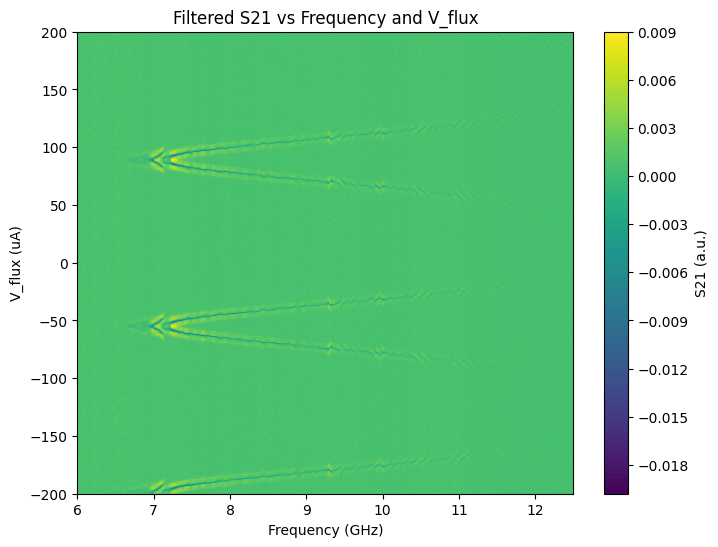

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

# Apply a uniform filter to calculate the local average for each point (3x3 neighborhood)
S21_avg = uniform_filter(S21, size=9)

# Identify extreme points where the difference from the average exceeds the threshold
extreme_points_mask = (S21 - S21_avg) < -0.004

# Plotting the filtered color plot
plt.figure(figsize=(8, 6))
plt.contourf(freq_grid, V_flux_grid, S21 - S21_avg, levels=100, cmap='viridis')
plt.colorbar(label='S21 (a.u.)')
plt.xlabel('Frequency (GHz)')
plt.ylabel('V_flux (uA)')
plt.title('Filtered S21 vs Frequency and V_flux')
plt.show()


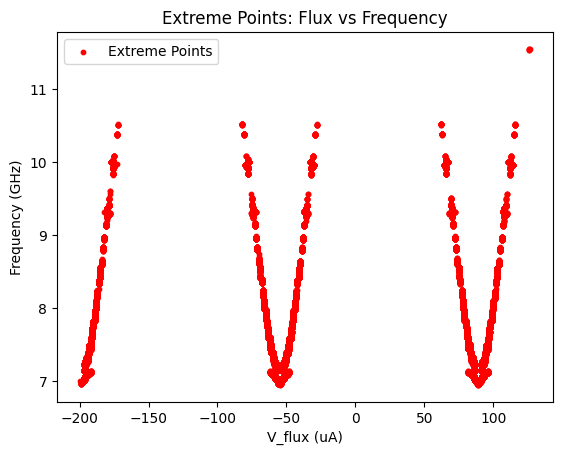

In [5]:

# Extract the frequency and flux values where the mask is True
flux_data = V_flux_grid[extreme_points_mask]
freq_data = freq_grid[extreme_points_mask]

plt.scatter(flux_data, freq_data, color='red', label='Extreme Points', s=10)
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Extreme Points: Flux vs Frequency')
plt.legend()
plt.show()

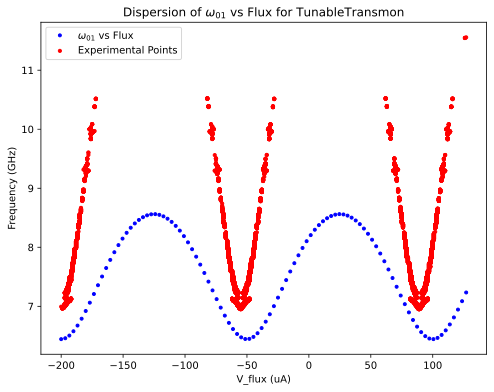

In [6]:
import scqubits as scq
import numpy as np
import matplotlib.pyplot as plt

def w01_flux(current, EJmax=13.206*1.*1, EC=0.836*1*1, ng=0.0, d=0.6, curr_shift=25, curr_flux_coef=0.5/75):
    # Define the TunableTransmon with the specified parameters
    ncut = 30  # Charge basis truncation, typical value for convergence

    flux = (current - curr_shift)* curr_flux_coef # L

    # Create an instance of TunableTransmon
    flux = np.array(flux).reshape(1, -1).flatten()

    # w01_list = np.zeros_like(flux)
    # for i, fl in enumerate(flux):
    #     # transmon = scq.TunableTransmon(EJmax=EJmax, EC=EC, ng=ng, ncut=ncut, d=0, flux=fl)
    #     # vals = transmon.eigenvals(evals_count=2)   
    #     # w01_list[i] = vals[1] - vals[0]
    #     w01_list[i] = np.sqrt((4*EC*(ng-1))**2 + (EJmax*np.cos(np.pi*fl))**2)

    # return w01_list
    EJ = EJmax  * np.sqrt(np.cos(np.pi*flux)**2 + d**2 * np.sin(np.pi*flux)**2)
    return np.sqrt(8*EC*EJ) - EC

    return np.sqrt( (4*EC*(ng-n))**2 + (EJmax*np.cos(np.pi*flux))**2 )

# Plot the dispersion (w01 against flux)
plt.figure(figsize=(8, 6))

full_flux_list = np.linspace(np.min(flux_data), np.max(flux_data), 100)
plt.plot(full_flux_list, [w01_flux(current=flux) for flux in full_flux_list],'.', label='$\omega_{01}$ vs Flux', color='blue')
plt.scatter(flux_data, freq_data, color='red', label='Experimental Points', s=10)
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Dispersion of $\omega_{01}$ vs Flux for TunableTransmon')
plt.legend()
plt.show()


In [7]:
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

def multi_start_optimization(f, xdata, ydata, initial_params, sigma, N, M, L, bounds=None):
    """
    Runs the optimization M times for each of the N Gaussian-distributed initial parameter samples,
    and selects the top L candidates based on the residual sum of squares (RSS).
    
    Parameters:
    - f: The function to fit.
    - xdata: Independent variable data.
    - ydata: Dependent variable data.
    - initial_params: Initial guesses for the parameters.
    - sigma: Standard deviation for each parameter to generate samples.
    - N: Number of initial parameter sets (samples) to generate.
    - M: Number of optimizations to run per sample.
    - L: Number of best-fitting candidates to select.
    - bounds: Optional bounds for parameters (default is None).
    
    Returns:
    - best_candidates: List of L best candidates with optimized parameters.
    - rss_list: Residual sum of squares for the L best candidates.
    """

    def generate_initial_guesses(initial_params, sigma, N, bounds):
        """
        Generates N initial parameter sets based on the initial guess with Gaussian noise.
        
        Parameters:
        - initial_params: List of initial guesses for the parameters.
        - sigma: List of standard deviations for each parameter (can be 0 for fixed params).
        - N: Number of samples to generate.
        
        Returns:
        - List of N parameter sets.
        """
        param_samples = []
        for i in range(N):
            sample = np.array(initial_params) + np.random.normal(0, sigma, len(initial_params))
            
            if bounds != None:
                for i, piece in enumerate(sample):
                    if piece < bounds[0][i]:
                        sample[i] = bounds[0][i]
                    elif piece > bounds[1][i]:
                        sample[i] = bounds[1][i]

            param_samples.append(sample)
        return param_samples

    def fit_function(f, xdata, ydata, initial_guess, bounds=None):
        """
        Performs curve fitting using the provided function `f` and data.
        
        Parameters:
        - f: The function to fit.
        - xdata: Independent variable data.
        - ydata: Dependent variable data.
        - initial_guess: Initial guess for parameters.
        - bounds: Optional bounds for parameters (default is None).
        
        Returns:
        - popt: Optimized parameters.
        - pcov: Covariance matrix of the parameters.
        """
        if bounds==None:
            popt, pcov = curve_fit(f, xdata, ydata, p0=initial_guess)
        else:
            popt, pcov = curve_fit(f, xdata, ydata, p0=initial_guess, bounds=bounds)
        return popt, pcov

    param_samples = generate_initial_guesses(initial_params, sigma, N, bounds)
    best_candidates = []
    rss_list = []

    for sample_idx, sample in enumerate(tqdm(param_samples)):
        for attempt in tqdm(range(M)):
            try:
                # Fit the function using the current sample
                popt, _ = fit_function(f, xdata, ydata, sample, bounds)
                
                # Compute residual sum of squares (RSS)
                residuals = ydata - f(xdata, *popt)
                rss = np.sum(residuals**2)
                
                # Append the result
                best_candidates.append((popt, rss))
                # print(f"Sample {sample_idx}, attempt {attempt}: Success with RSS = {rss}")
            except Exception as e:
                print(f"Sample {sample_idx}, attempt {attempt}: Failed with error: {e}")
    
    # Sort candidates based on RSS (lower RSS is better)
    best_candidates.sort(key=lambda x: x[1])
    
    # Select the top L candidates if available
    if len(best_candidates) > 0:
        best_candidates = best_candidates[:min(L, len(best_candidates))]
        rss_list = [rss for _, rss in best_candidates]

    # Return only the optimized parameters and their RSS values
    return [popt for popt, _ in best_candidates], rss_list

# Example usage

# Example data (xdata and ydata)
xdata = flux_data.copy()
ydata = freq_data.copy()

# Parameters
initial_params = [13.206*1.*1, 0.836*1*1, 0.0, 0.6, 25, 0.5/75]
sigma = [5, 0.01, 0.3, 0.6, 25, 0.5/75*0.5]  # Standard deviations for [a, b, c]
bounds=[[0, 0.7, -0.3, 0, -50, -0.5/75*2], [100, 0.9, 0.01, 1, 50, 0.5/75*2]]
N = 5  # Number of initial parameter sets
M = 1   # Number of optimization attempts per parameter set
L = 1   # Number of best candidates to select

# Run the multi-start optimization
best_candidates, rss_list = multi_start_optimization(w01_flux, xdata, ydata, initial_params, sigma, N, M, L, bounds=bounds)

# Display the results
if best_candidates:
    print("Best Candidates (parameters):", best_candidates)
    print("Residual Sum of Squares (RSS) for Best Candidates:", rss_list)
else:
    print("No valid candidates found.")

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

Best Candidates (parameters): [array([ 3.70088388e+01,  7.00002852e-01, -2.98450000e-01,  2.89619864e-01,
        1.70469604e+01,  6.94326966e-03])]
Residual Sum of Squares (RSS) for Best Candidates: [np.float64(112.1270395378202)]


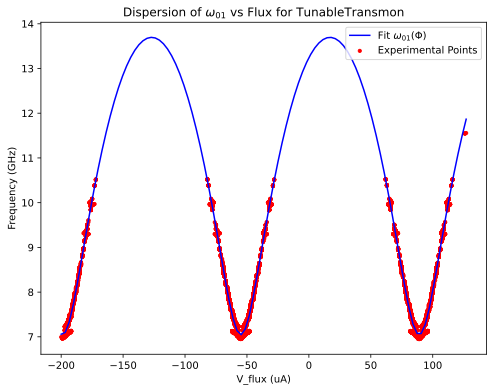

In [8]:
xfull = np.linspace(np.min(xdata), np.max(xdata), 100)

plt.figure(figsize=(8, 6))
plt.plot(xfull, w01_flux(xfull, *best_candidates[0]), label='Fit $\omega_{01}(\Phi)$', color='blue')
plt.scatter(flux_data, freq_data, color='red', label='Experimental Points', s=10)
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Dispersion of $\omega_{01}$ vs Flux for TunableTransmon')
plt.legend()
plt.show()

In [9]:
print(f"EJ={round(best_candidates[0][0],2)} GHz")
print(f"EC={round(best_candidates[0][1],2)} GHz")
print(f"ng={round(best_candidates[0][2],2)}")
print(f"current-to-flux coef={round(best_candidates[0][4],5)} Φ0/uA")
print(f"frozen flux={round(best_candidates[0][3]*best_candidates[0][4],2)} Φ0")

EJ=37.01 GHz
EC=0.7 GHz
ng=-0.3
current-to-flux coef=17.04696 Φ0/uA
frozen flux=4.94 Φ0


In [10]:
flux = best_candidates[0][3]*best_candidates[0][4] + (-45) * best_candidates[0][4]
transmon = scq.TunableTransmon(EJmax=best_candidates[0][0], EC=best_candidates[0][1], ng=0.2, ncut=30, d=0, flux=0)
vals = transmon.eigenvals(evals_count=3) 
w01 = vals[1] - vals[0]
w12 = vals[2] - vals[1]

print(w01, w12) # TODO Is it too big???

13.656828219876058 12.856572347970303


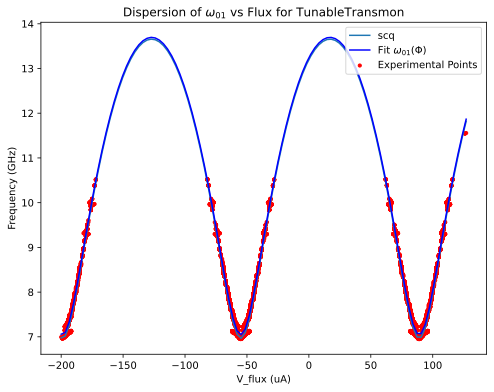

In [11]:
def w01_flux_scq(current, EJmax=13.206*1.*1, EC=0.836*2*1, ng=0.0, d=0.6, curr_shift=25, curr_flux_coef=0.5/75):
    # Define the TunableTransmon with the specified parameters
    ncut = 30  # Charge basis truncation, typical value for convergence

    flux = (current - curr_shift)* curr_flux_coef # L

    # Create an instance of TunableTransmon
    flux = np.array(flux).reshape(1, -1).flatten()

    w01_list = np.zeros_like(flux)
    for i, fl in enumerate(flux):
        transmon = scq.TunableTransmon(EJmax=EJmax, EC=EC, ng=0.2, ncut=ncut, d=d, flux=fl)
        vals = transmon.eigenvals(evals_count=2)   
        w01_list[i] = vals[1] - vals[0]
    return w01_list

    # return np.sqrt((4*EC*(ng-1))**2 + (EJmax*np.cos(np.pi*flux))**2)

plt.figure(figsize=(8, 6))
plt.plot(xfull, w01_flux_scq(xfull, *best_candidates[0]), label='scq')
plt.plot(xfull, w01_flux(xfull, *best_candidates[0]), label='Fit $\omega_{01}(\Phi)$', color='blue')
plt.scatter(flux_data, freq_data, color='red', label='Experimental Points', s=10)
plt.ylabel('Frequency (GHz)')
plt.xlabel('V_flux (uA)')
plt.title('Dispersion of $\omega_{01}$ vs Flux for TunableTransmon')
plt.legend()
plt.show()

# TODO they do not match
